In [ ]:
!pip install qiskit

In [ ]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import transpile, schedule as build_schedule
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel,ShiftPhase, Drag
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_histogram

In [ ]:

IBMQ.save_account('24f1bb2782a6cfdd06501f5146b73ad546e8892fa55e1da503fb632e8400aee65f9bc6ff5f62eca98bb131ea7e71f8420edde7448ecdd1fac11b348161a517ae')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

configrc.store_credentials:WARNING:2020-11-13 22:26:13,039: Credentials already present. Set overwrite=True to overwrite.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-13 22:26:13,362: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [ ]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()

In [ ]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974448669590939 GHz.
The sweep will go from 4.954448669590938 GHz to 4.9944486695909385 GHz in steps of 1.0 MHz.


In [ ]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [ ]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play,Drag
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [ ]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [ ]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [ ]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [ ]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

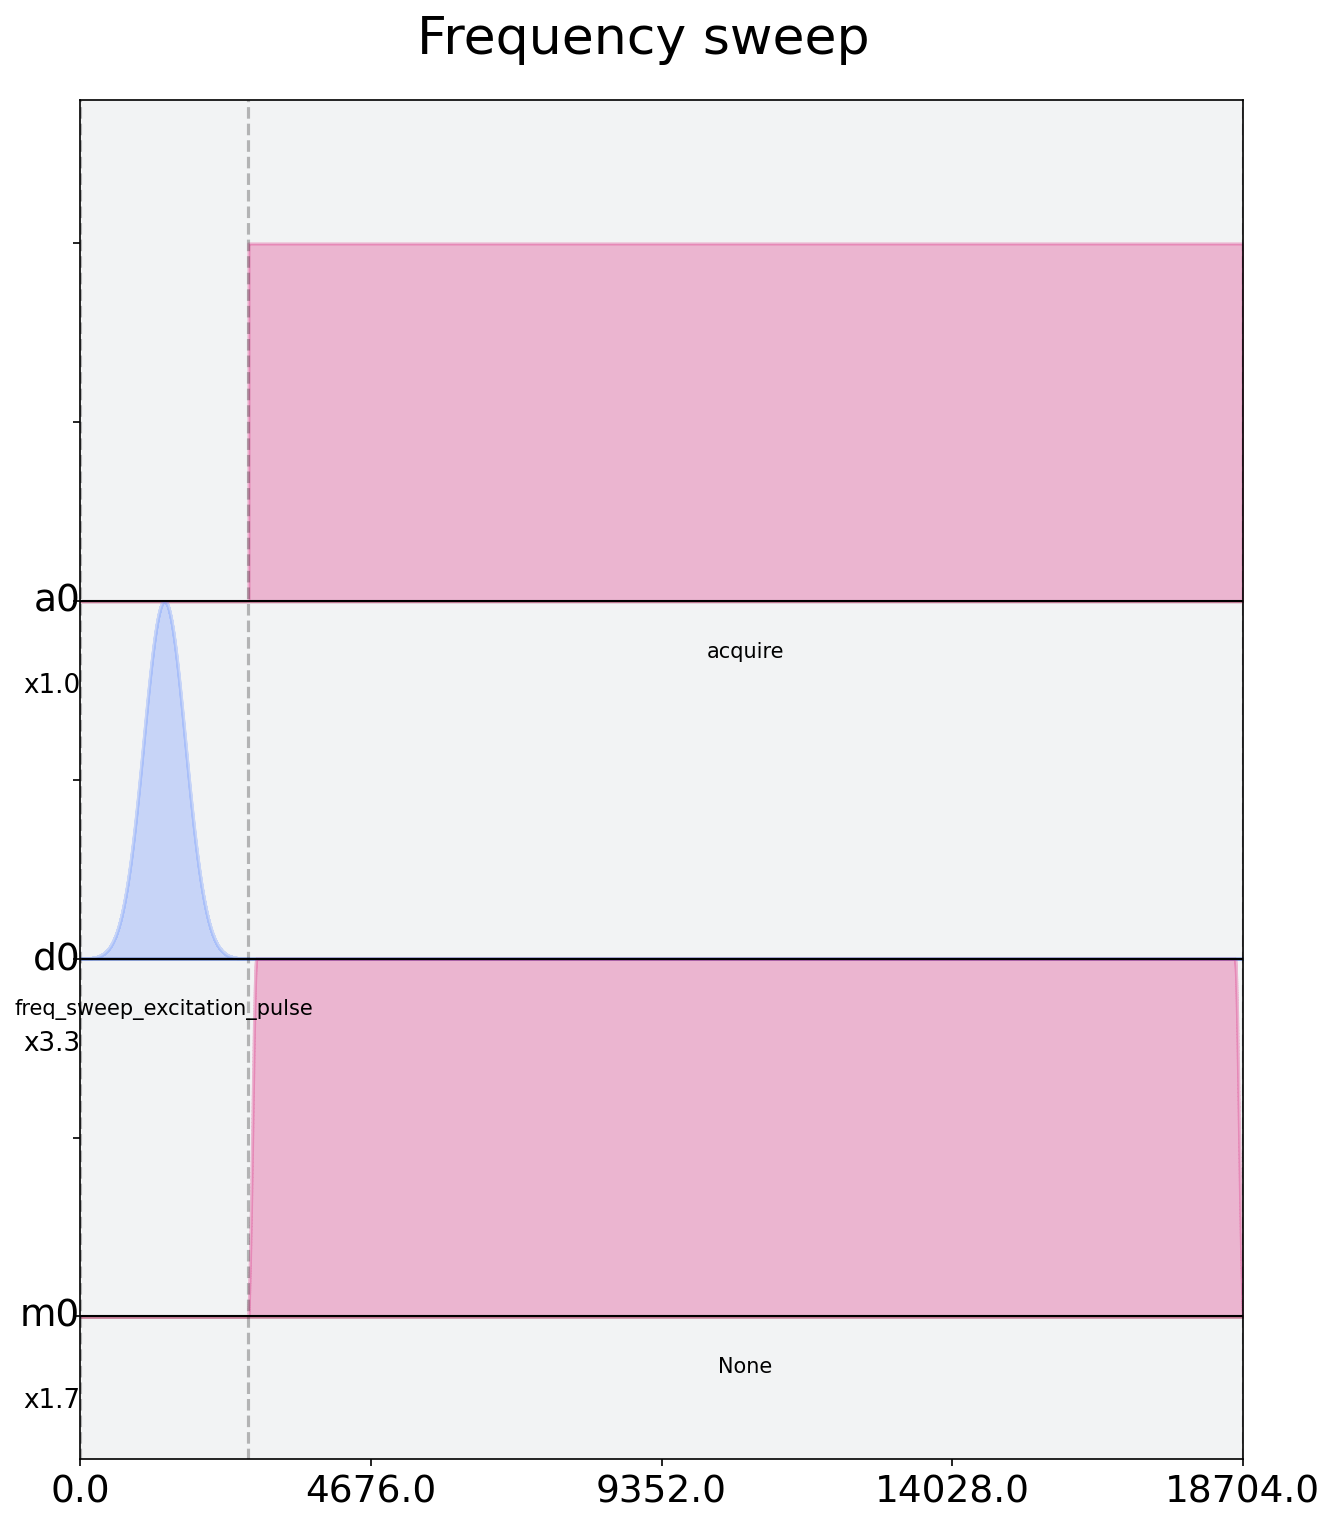

In [ ]:
schedule.draw(label=True)

In [ ]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [ ]:
job = backend.run(frequency_sweep_program)

In [ ]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [ ]:
 
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

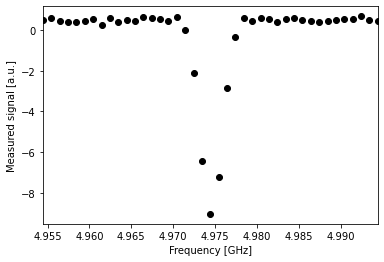

In [ ]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

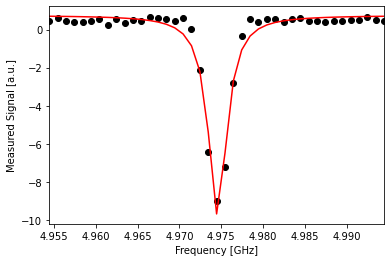

In [ ]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97456 GHz.


In [ ]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 75

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

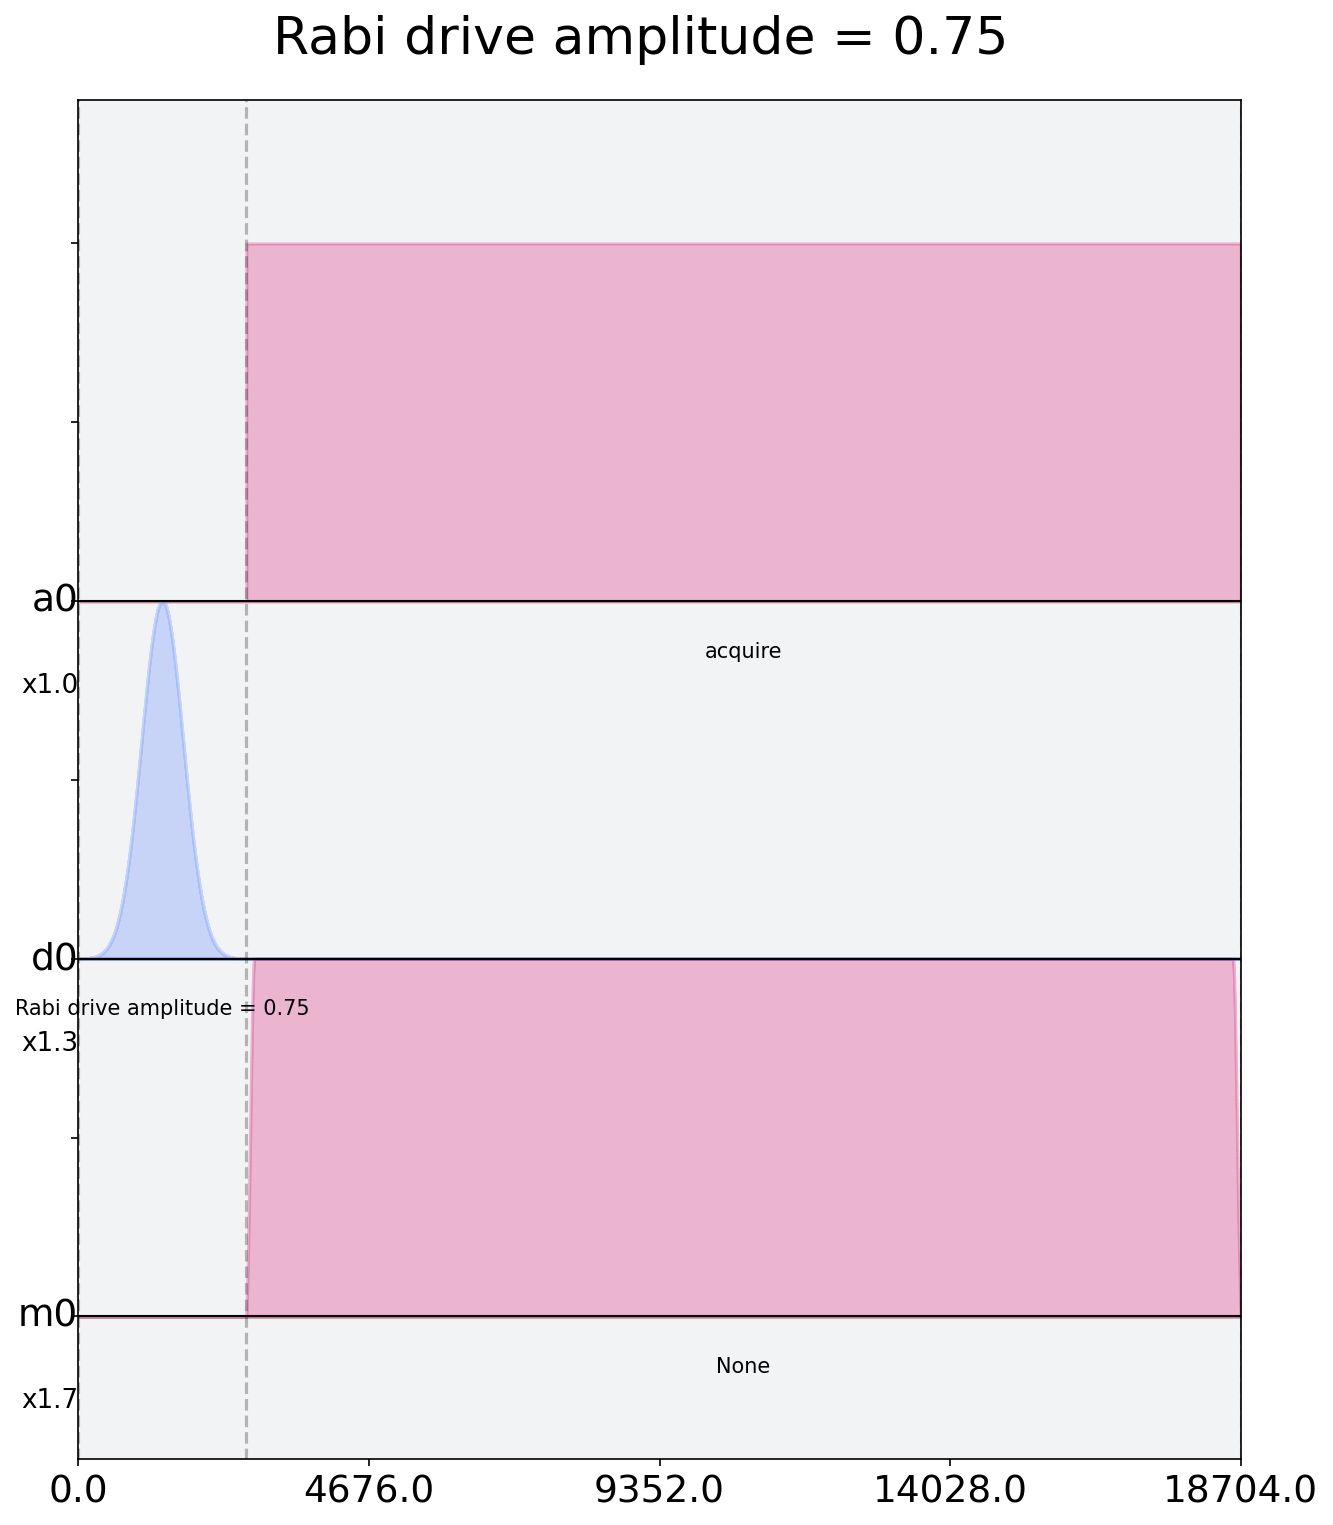

In [ ]:
rabi_schedules[-1].draw(label=True)

In [ ]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [ ]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [ ]:
rabi_results = job.result(timeout=120)

[(0.19654659538944-1.68822396944384j), (0.33327574679552-1.6780856655872j), (0.2111041437696-1.71809144045568j), (0.06596118183936-1.57983979864064j), (-0.72152548114432-1.60106717118464j), (-1.3727667585024-1.49965242368j), (-1.80797352968192-1.3985000718336j), (-2.0799603867648-1.21581833551872j), (-3.5353503203328-1.13441981333504j), (-4.44748829556736-1.07140500946944j), (-4.8693067644928-0.80515084320768j), (-6.13137317363712-0.73035549769728j), (-6.7320860901376-0.42990286405632j), (-7.58815628722176-0.33570666053632j), (-8.7390437769216-0.2833793417216j), (-8.83900779855872+0.07155783041024j), (-10.02308666130432-0.09252741578752j), (-10.35696869474304+0.01584770973696j), (-11.24467602358272+0.12915353583616j), (-11.4520202674176-0.00998829391872j), (-11.49318618677248+0.30839219945472j), (-11.91644581855232+0.24743931543552j), (-11.77271876452352+0.3419828912128j), (-12.15260862185472+0.20127571509248j), (-11.36761342263296+0.1901564264448j), (-10.8246060761088+0.24046777401344

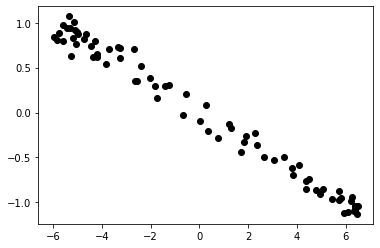

In [ ]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

print(rabi_values)
plt.scatter(np.real(baseline_remove(rabi_values)), np.imag(baseline_remove(rabi_values)), color='black') # plot real part of Rabi values
plt.show()


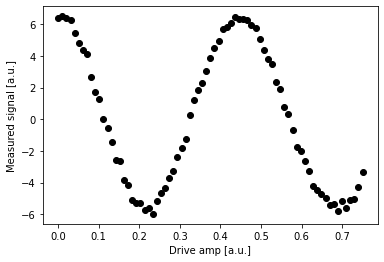

In [ ]:
rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

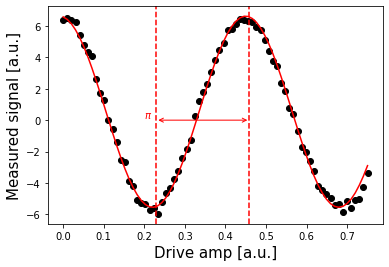

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.22942752824146204


In [ ]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [ ]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

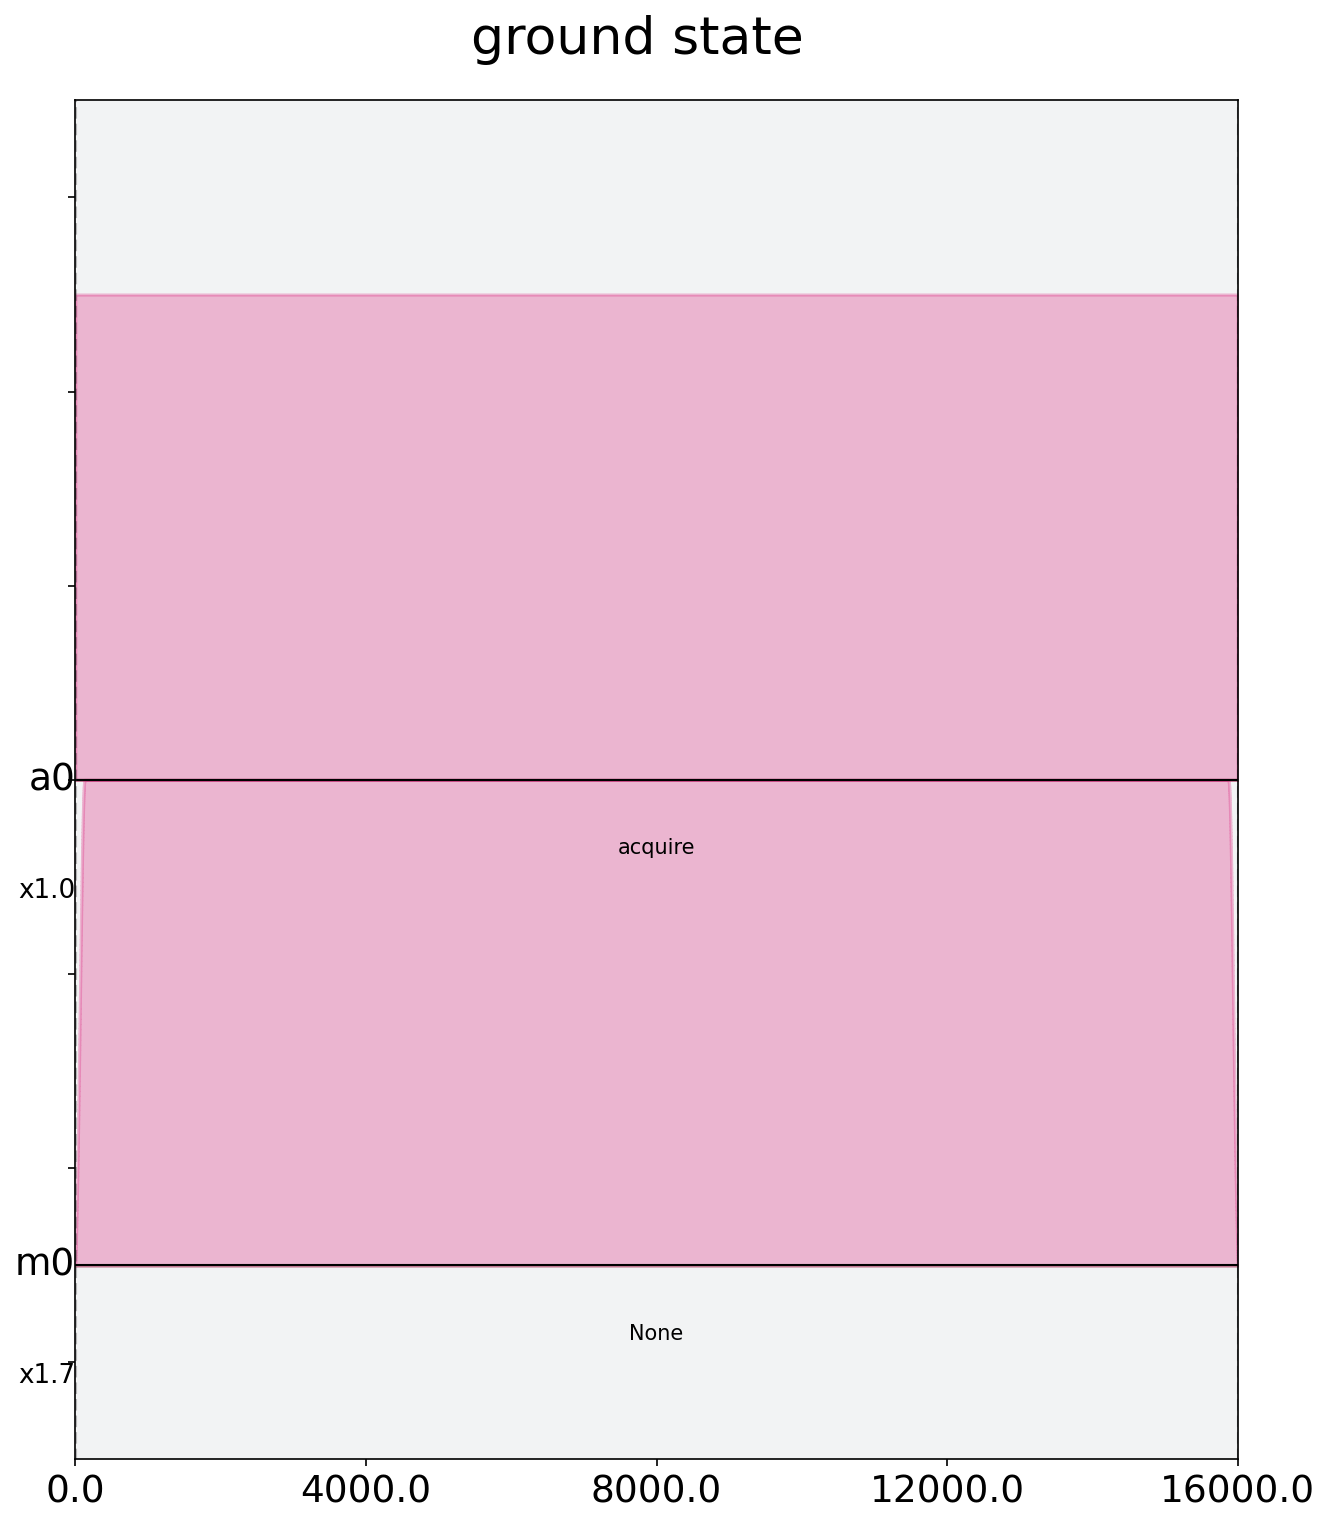

In [ ]:
gnd_schedule.draw(label=True)

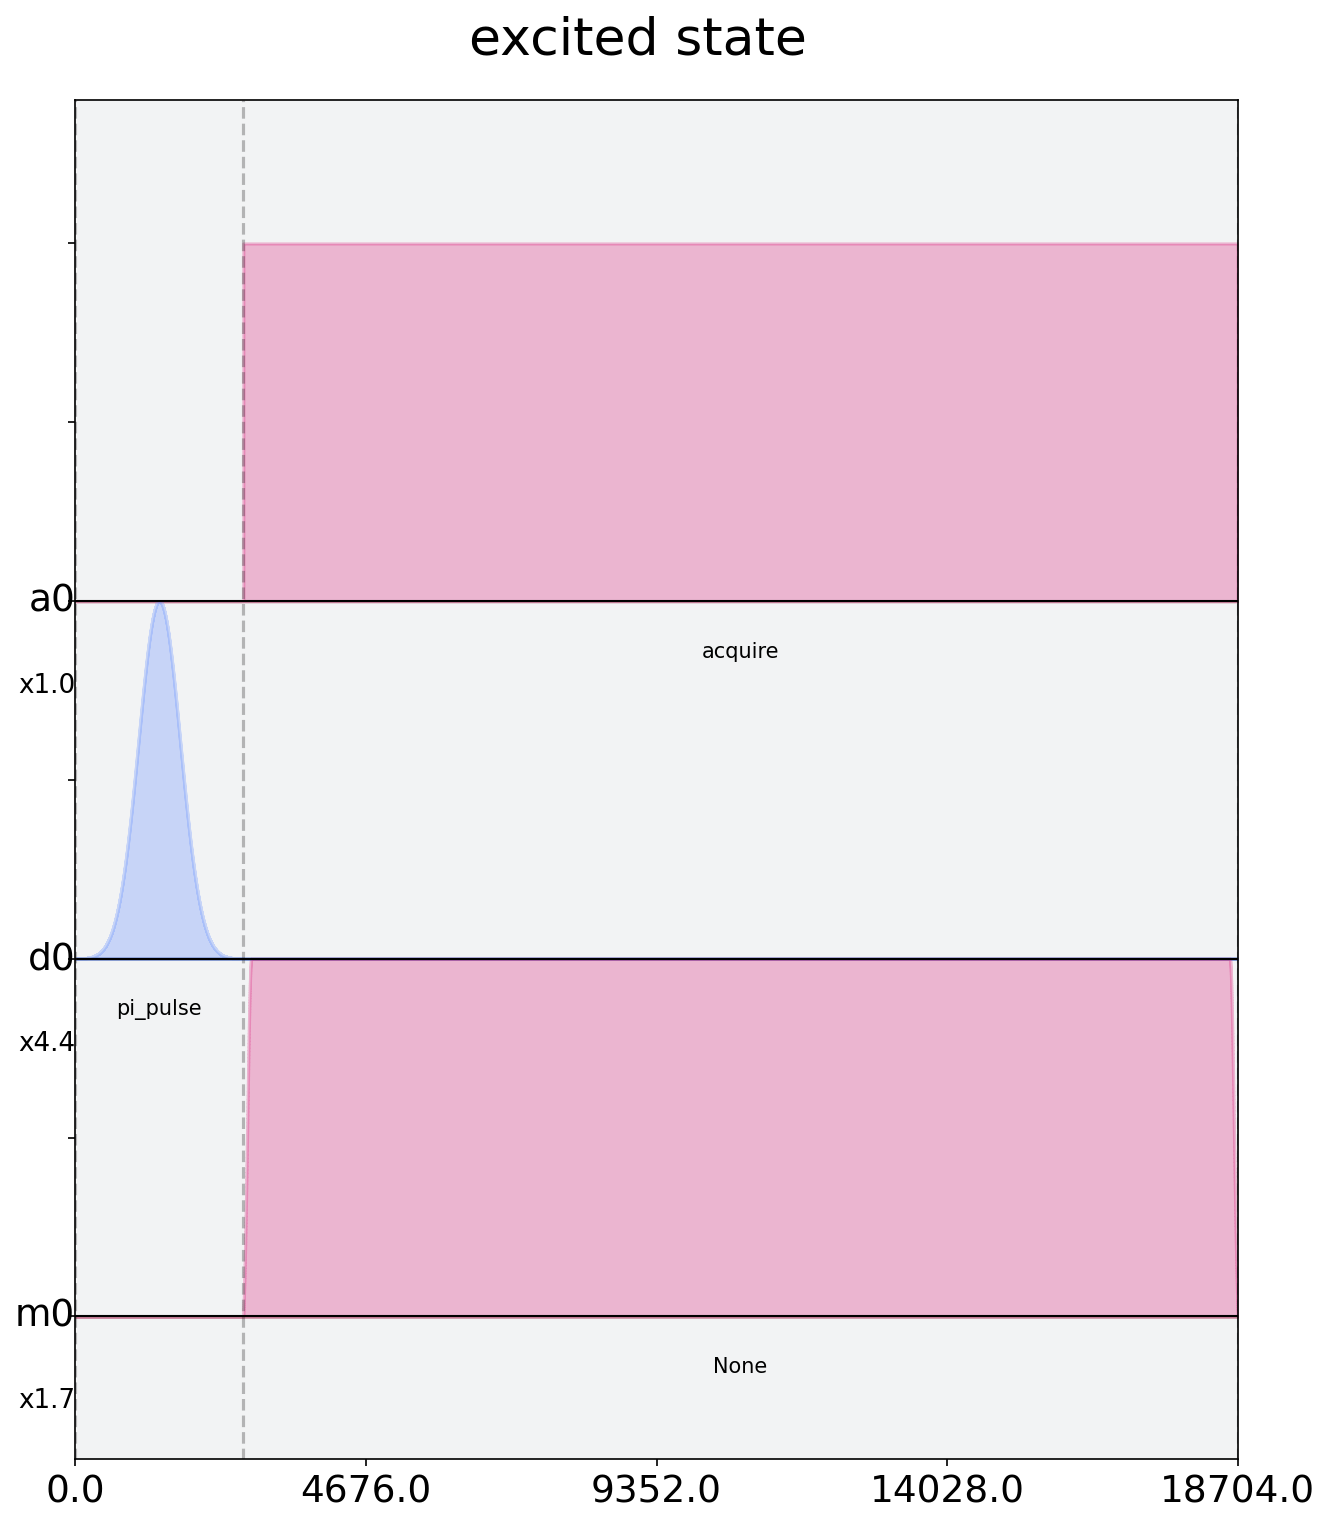

In [ ]:
exc_schedule.draw(label=True)

In [ ]:
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [ ]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
 gnd_exc_results = job.result(timeout=120)

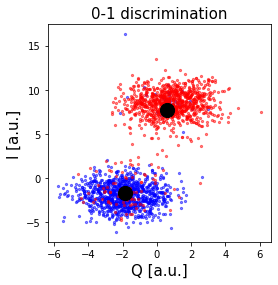

In [ ]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

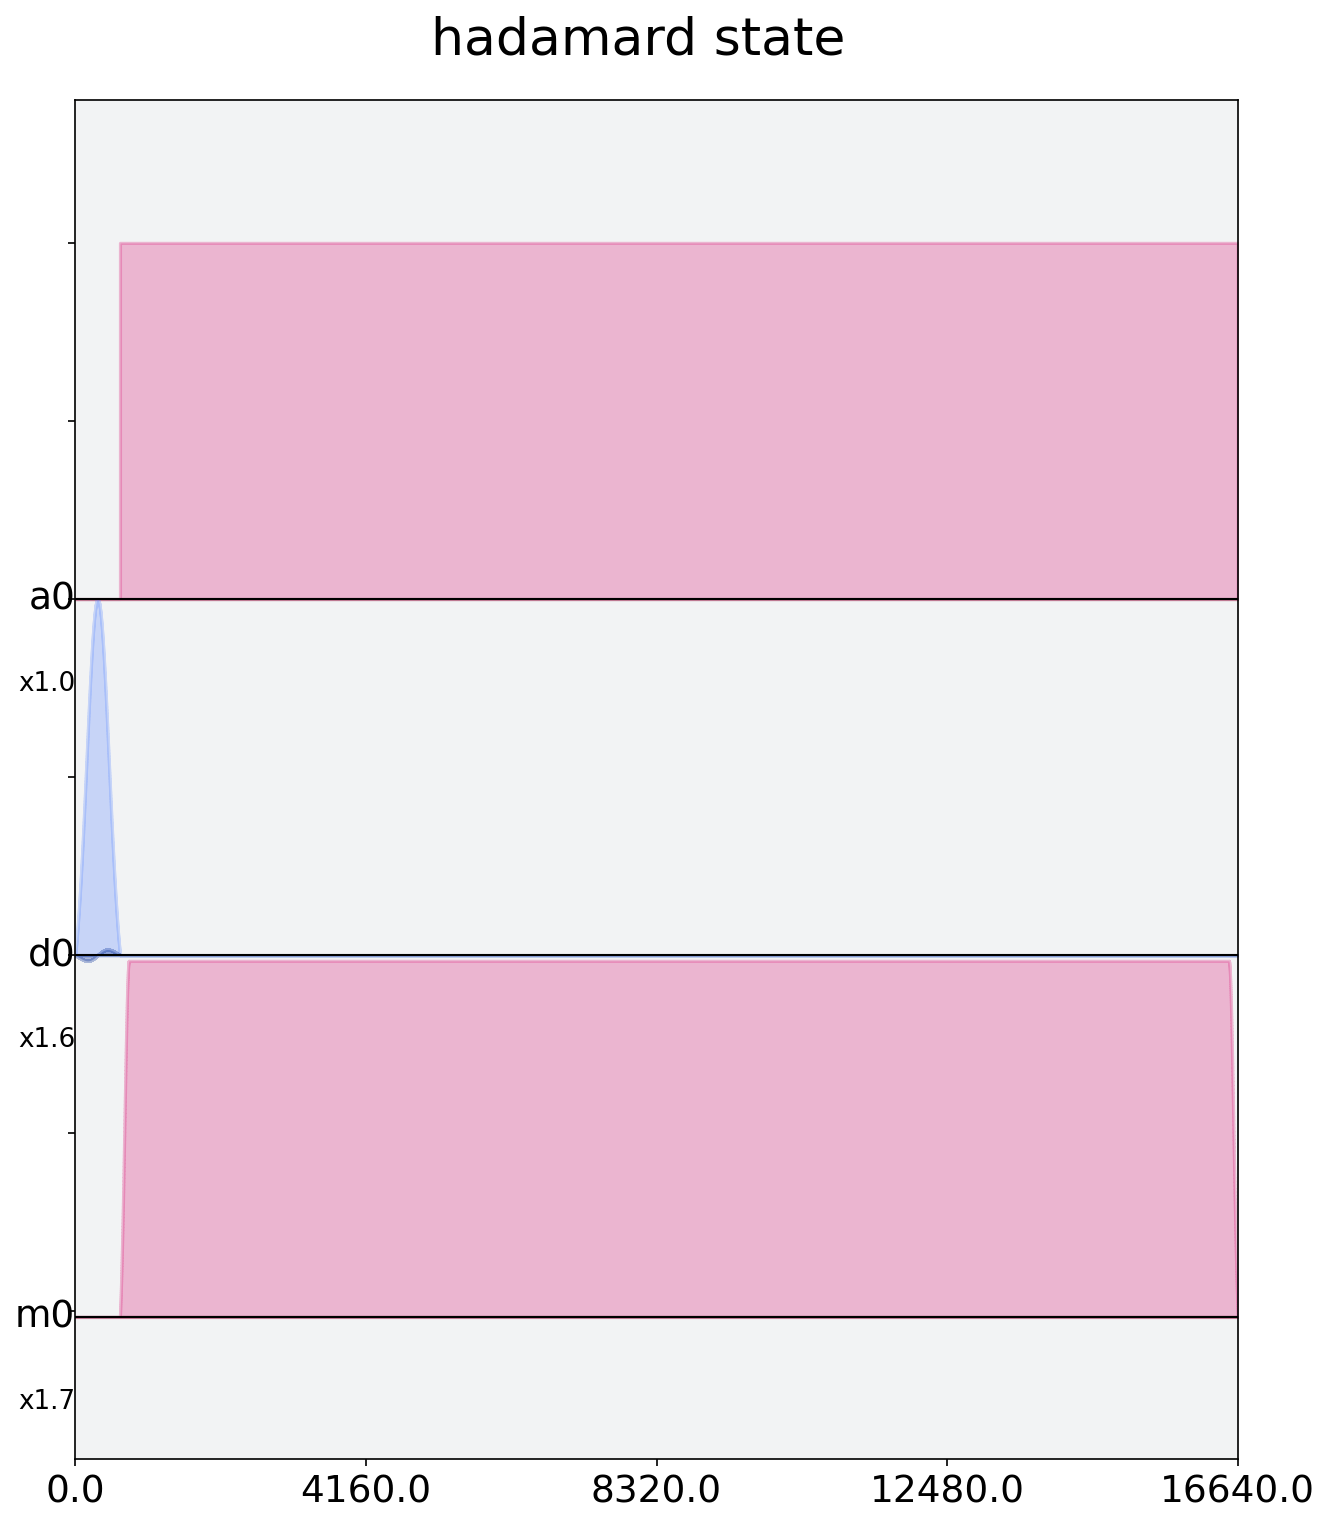

In [ ]:

x_pulse = Drag(duration=640,
                              amp=0.6398782833362591+0j, 
                              sigma=160,
                              beta=-4.583585010853577,
                              name='h_pulse')


sched_circuit = pulse.Schedule(name="hadamard state")
#sched_circuit |= ShiftPhase(-np.pi, drive_chan) 
sched_circuit |= Play(x_pulse, drive_chan) 
#sched_circuit += ShiftPhase(-0.0, drive_chan)  
sched_circuit += measure << 640
sched_circuit.draw()


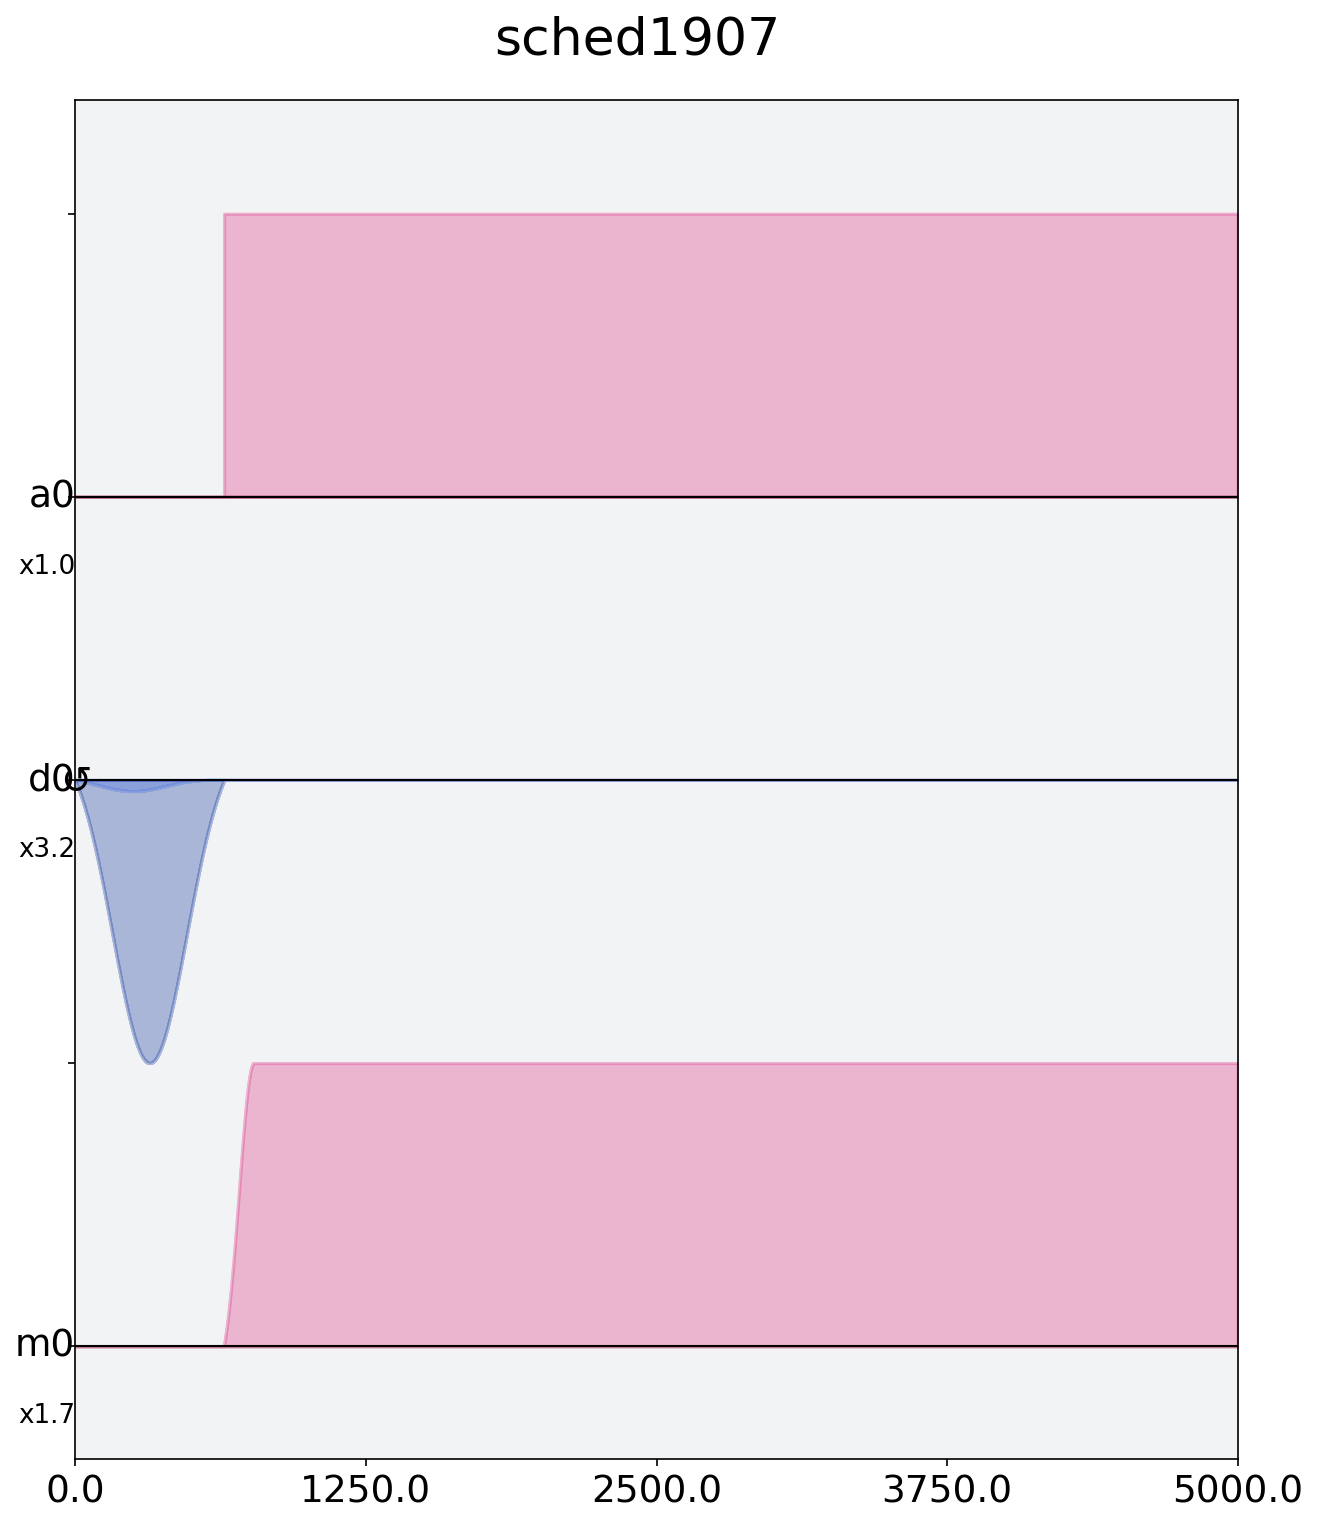

In [ ]:
with pulse.build(backend) as u2_sched:
    pulse.u2(0, np.pi,0)

u2_sched += measure << u2_sched.duration
u2_sched.draw(plot_range=(0,5000))

In [ ]:
print(inst_sched_map)
inst_sched_map.get('u1', 0,P0=np.pi)

<InstructionScheduleMap(1Q instructions:
  q0: {'id', 'u2', 'measure', 'u3', 'u1', 'x'}
Multi qubit instructions:
)>


Schedule((0, ShiftPhase(-3.141592653589793, DriveChannel(0))), name="u1")

In [ ]:
num_shots = 1024

h_exc_program = assemble([sched_circuit],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [ ]:
# print(job.job_id())
job = backend.run(h_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
h_exc_results = job.result(timeout=120)

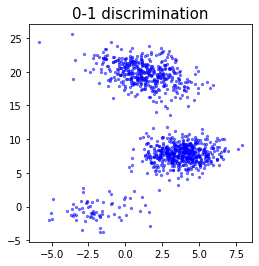

In [ ]:
h_results = h_exc_results.get_memory(0)[:, qubit]*scale_factor
#exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(h_results), np.imag(h_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
res = [x for x in [classify(complex(n.real,n.imag)) for n in h_results]]

In [ ]:
print(f'0 count : {res.count(0)}')
print(f'1 count : {res.count(1)}')

0 count : 69
1 count : 955


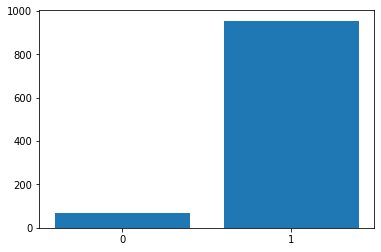

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.bar([0,1],[res.count(0),res.count(1)])
plt.xticks([0,1])
plt.show()

In [ ]:
x = 